<a href="https://colab.research.google.com/github/Alexey504/CV_Rocket/blob/main/lesson1/CV_Rocket_hw1_main_ALEXEY_MATVEEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание: Сбор данных, автоматическая разметка и оценка качества (50 баллов)
В этом задании вы научитесь:
- загружать изображения из открытых датасетов;
- применять предобученные модели для автоматической разметки;
- оценивать качество разметки с помощью базовых метрик;
- сравнивать сходимость между результатами разных разметок.

Это важно, потому что автоматическая разметка помогает ускорять работу над CV-датасетами, особенно при построении пайплайнов активного обучения или semi-supervised подходов.


### Установим все необходимые зависимости:

In [2]:
!pip install -q roboflow ultralytics
!pip install -q inference-sdk
!pip install -q torch torchvision

In [3]:
from typing import List, Tuple

In [ ]:
import shutil

shutil.rmtree('People-Detection-1')

## Работа с данными

Начнем работу с датасетами из Roboflow. В этом домашнем задании расмотрим задачу детекции людей.

Для того чтобы скачать данные, необходимо зарегистрировать на Roboflow https://roboflow.com/ и использовать свой API-ключ.

API-ключ можно найти в личном кабинете в разделе Settings->API Keys

Используйте Private API Key

#### **Задание (2 балла)**:
Скачайте с Roboflow вот этот датасет https://universe.roboflow.com/leo-ueno/people-detection-o4rdr
Визуализируйте 6 случайных изображений


In [4]:
from roboflow import Roboflow
from google.colab import userdata


# TODO: Воспользуйтесь API-ключом, загрузите и визуализируйте датасет
# ---- Ваш код здесь ----
api_key = userdata.get('ROBOFLOWAPIKEY')
rf = Roboflow(api_key=api_key)
project = rf.workspace("leo-ueno").project("people-detection-o4rdr")
version = project.version(1)
dataset = version.download("yolov8")
# ---- Конец кода ----



loading Roboflow workspace...
loading Roboflow project...


Перед тем как применять автоматическую разметку или оценивать качество аннотаций, важно визуально ознакомиться с содержимым датасета.
Это помогает:
- понять, насколько разнообразны сцены;
- определить, есть ли шумные или пустые изображения;
- проверить, соответствуют ли изображения ожидаемому формату (цвет, размер, объекты).

## Визуализация изображений

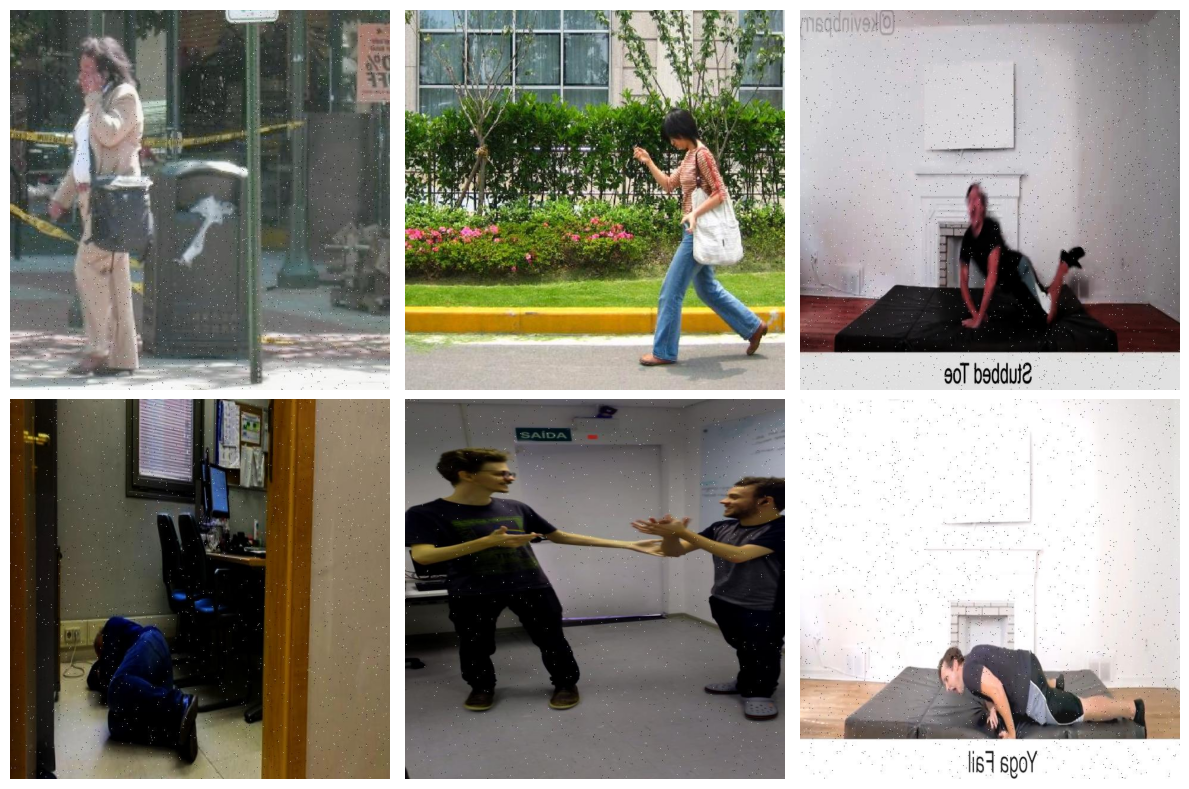

In [5]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

image_dir = "People-Detection-1/train/images"
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

random_images = random.sample(image_files, 6)

plt.figure(figsize=(12, 8))
for i, img_name in enumerate(random_images):
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Разметка данных

Для того, чтобы понять что такое разметка и как с ней работать, сымитируем процесс разметки с помщью моделей.


Выберите и примените 3 предобученные модели (YOLOv8n, YOLOv8m, Faster R-CNN) для автоматической разметки изображений. Сохраните или выведите bounding boxes только для класса person.

#### **Задание (10 баллов)**:
загрузите модели 2 модели YOLO и 1 Faster R-CNN и получите результат разметки

In [6]:
from ultralytics import YOLO
# ---- Ваш код здесь ----
# M1: YOLOv8n (на COCO)
model_yolo_n = YOLO('yolov8n.pt')
# model_yolo_n.to('cuda')
# M2: YOLOv8m (на COCO)
model_yolo_m = YOLO('yolov8m.pt')
# model_yolo_m.to('cuda')
# ---- Конец кода ----

In [7]:
import torchvision
import torchvision.transforms as T
import torch
from PIL import Image

# Загрузка модели
model_frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_frcnn.eval()

transform = T.ToTensor()

def run_frcnn(img_path):
  image = Image.open(img_path)
  image = transform(image)
  # ---- Ваш код здесь ----
  with torch.no_grad():
    output = model_frcnn([image])[0]
  # ---- Конец кода ----
    return output  # содержит .boxes, .labels, .scores


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.


In [ ]:
import os

# Путь к изображениям
image_dir = "People-Detection-1/train/images"
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')])
# Ограничьте количество изображения
image_paths = [os.path.join(image_dir, f) for f in image_files][:120]

# ---- Ваш код здесь ----
results_yolo_n = model_yolo_n(image_paths, classes=0)
results_yolo_m = model_yolo_m(image_paths, classes=0)
results_faster_rcnn = list(map(lambda image_path: run_frcnn(image_path), image_paths))
# ---- Конец кода ----

### Визуализируйте результаты разметки

Перед тем как оценивать результаты разметки, необходимо визуально оценить как выглядит разметка

#### Задание(2 баллов):
Визуализируйте результаты разметки Yolo и Faster R-CNN

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch

def plot_person_boxes_all_models(image_path, yolo_result=None, frcnn_result=None, rf_result=None, model_name=""):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # --- YOLOv8 результат ---
    if yolo_result is not None:
      # ---- Ваш код здесь ----

      boxes = yolo_result.boxes.xyxy
      boxes = boxes.numpy()
      # classes = yolo_result.boxes.cls.numpy()
      for box in boxes:
        x1, y1, x2, y2 = box

        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False,
                             linewidth=2, color='blue')
        ax.add_patch(rect)
      # ---- Конец кода ----

    # --- Faster R-CNN результат ---
    if frcnn_result is not None:
      # ---- Ваш код здесь ----
      person_boxes = frcnn_result['boxes'][frcnn_result['labels'] == 1]
      for box in person_boxes:
        box = box.numpy()
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             fill=False, linewidth=2, color='red')
        ax.add_patch(rect)
      # ---- Конец кода ----
    plt.title(model_name)
    plt.axis('off')
    plt.show()

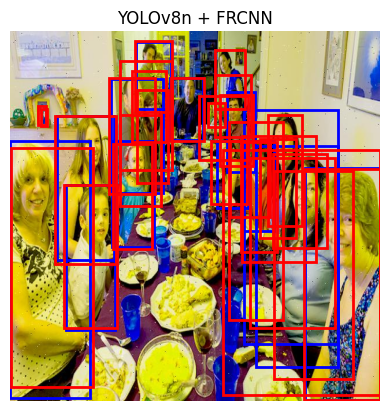

In [10]:
i = 12  # индекс изображения
plot_person_boxes_all_models(
    image_path=image_paths[i],
    yolo_result=results_yolo_n[i],
    frcnn_result=results_faster_rcnn[i],  # или None, если ты не используешь FRCNN
    model_name="YOLOv8n + FRCNN"
)

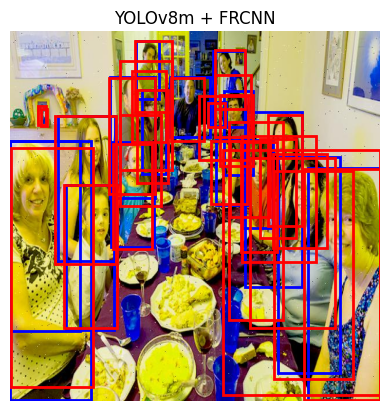

In [11]:
i = 12  # индекс изображения
plot_person_boxes_all_models(
    image_path=image_paths[i],
    yolo_result=results_yolo_m[i],
    frcnn_result=results_faster_rcnn[i],  # или None, если ты не используешь FRCNN
    model_name="YOLOv8m + FRCNN"
)

## Оценка результатов разметки

### Выделение результатов разметки

#### Задание(10 баллов):
Для всех результатов "разметки" выдели только ббоксы связанные с классом person

In [12]:
def extract_yolo_boxes(result) -> List[List[float]]:
    """
    Возвращает список bbox'ов класса 'person' (class_id = 0) из YOLOv8 результата.

    Parameters:
        result: объект результата модели YOLOv8 (ultralytics.engine.results.Results)

    Returns:
        List[List[float]]: список прямоугольников [x1, y1, x2, y2]
    """
    # ---- Ваш код здесь ----
    result = result.boxes.xyxy

    # ---- Конец кода ----
    return result

In [13]:
def extract_frcnn_boxes(result, threshold=0.5):
      """
    Извлекает bbox'ы класса 'person' из результата Faster R-CNN при score >= threshold.

    Параметры:
        result (dict): результат модели Faster R-CNN с ключами 'boxes', 'labels', 'scores'.
        threshold (float): минимальный порог уверенности (по умолчанию 0.5).

    Возвращает:
        List[List[float]]: список bbox в формате [x1, y1, x2, y2], только для класса 'person' (label = 1).
    """
   # ---- Ваш код здесь ----
      person_conf = torch.logical_and(result['labels'] == 1, result['scores'] >= threshold)
      result = result['boxes'][person_conf]
    # ---- Конец кода ----
      return result

In [ ]:
results_faster_rcnn[12]['scores'][results_faster_rcnn[12]['scores'] > 0.5]

tensor([0.9891, 0.9586, 0.9424, 0.9376, 0.9282, 0.9260, 0.9190, 0.9122, 0.9058, 0.8960, 0.8703, 0.8658, 0.8613, 0.8565, 0.8564, 0.8382, 0.8263, 0.8160, 0.7490, 0.7218, 0.7208, 0.7151, 0.6909, 0.6432, 0.5958, 0.5709, 0.5621, 0.5502, 0.5289, 0.5225])

In [ ]:
results_faster_rcnn[0]['boxes'][torch.logical_and(results_faster_rcnn[0]['labels'] == 1, results_faster_rcnn[0]['scores'] > 0.5)]

tensor([], size=(0, 4))

In [20]:
boxes_yolo_n = [extract_yolo_boxes(r) for r in results_yolo_n]
boxes_yolo_m = [extract_yolo_boxes(r) for r in results_yolo_m]
boxes_faster_rcnn = [extract_frcnn_boxes(r) for r in results_faster_rcnn]

### Подсчет метрик разметки

#### Задание(10 баллов):
Посчитайте IoU метрику между ббоксами и оцените согласованность между разметками

In [15]:
def compute_iou(boxA, boxB) -> float:
    """
    Вычисляет IoU (Intersection over Union) между двумя прямоугольниками.

    Параметры:
        boxA (List[float]): координаты первого bbox [x1, y1, x2, y2]
        boxB (List[float]): координаты второго bbox [x1, y1, x2, y2]

    Возвращает:
        float: значение IoU от 0 до 1
    """
      # ---- Ваш код здесь ----
      # области пересечения
    # print('boxA', boxA, '\n', boxB)
    if not len(boxA) and not len(boxB):
      return 1.0
    elif not len(boxA) or not len(boxB):
      return 0.0
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # площадь пересечения
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # площади каждого пу
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # подсчет iou
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # ---- Конец кода ----
    return iou

In [16]:
import numpy as np

In [17]:
def iou_agreement(boxes_a, boxes_b, iou_thresh=0.5) -> float:
    """
    Вычисляет долю bbox'ов из A, которые согласованы с bbox'ами из B по IoU >= порога.

    Параметры:
        boxes_a (List[List[float]]): список bbox модели A
        boxes_b (List[List[float]]): список bbox модели B
        iou_thresh (float): порог IoU для согласия (по умолчанию 0.5)

    Возвращает:
        float: доля согласованных bbox (от 0 до 1)
    """
    # ---- Ваш код здесь ----
    if not len(boxes_a) and not len(boxes_b):
      return 1.0
    elif not len(boxes_a) or not len(boxes_b):
      return 0.0

    matched = 0
    for box_a, box_b in zip(boxes_a, boxes_b):
      iou = compute_iou(box_a, box_b)
      if iou >= iou_thresh:
          matched += 1
          break
    iou_percent = matched / len(boxes_a)

    # ---- Конец кода ----
    return iou_percent

In [18]:

def mean_iou_agreement(all_a, all_b) -> float:
    """
    Вычисляет среднюю долю согласованных bbox по всему датасету.

    Параметры:
        all_a (List[List[List[float]]]): список bbox'ов по изображениям модели A
        all_b (List[List[List[float]]]): список bbox'ов по изображениям модели B

    Возвращает:
        float: среднее значение IoU согласия по изображениям
    """
    # ---- Ваш код здесь ----
    all_agr = []
    for bbox_a, bbox_b in zip(all_a, all_b):
      agr = iou_agreement(bbox_a, bbox_b)
      all_agr.append(agr)
    mean_iou = np.mean(all_agr)
    # ---- Конец кода ----
    return mean_iou

In [21]:
agreement_1_2 = mean_iou_agreement(boxes_yolo_n, boxes_yolo_m)
agreement_1_3 = mean_iou_agreement(boxes_yolo_n, boxes_faster_rcnn)
agreement_2_3 = mean_iou_agreement(boxes_yolo_m, boxes_faster_rcnn)

print(f"Сходимость M1 vs M2: {agreement_1_2:.2f}")
print(f"Сходимость M1 vs M3: {agreement_1_3:.2f}")
print(f"Сходимость M2 vs M3: {agreement_2_3:.2f}")

Сходимость M1 vs M2: 0.58
Сходимость M1 vs M3: 0.54
Сходимость M2 vs M3: 0.59


#### Задание(10 баллов):
Проанализируйте метрики сходимости precision, recall, f1 и Cohen’s Kappa.

In [22]:
def match_predictions(pred_boxes, ref_boxes, iou_thresh=0.5) -> Tuple[int, int, int]:
    """
    Сопоставляет предсказанные bbox с эталонными и возвращает TP, FP, FN.

    Параметры:
        pred_boxes (List[List[float]]): список bbox от модели
        ref_boxes (List[List[float]]): список bbox из эталона (GT или другой модели)
        iou_thresh (float): порог для совпадения IoU

    Возвращает:
        Tuple[int, int, int]: TP, FP, FN
    """
    # ---- Ваш код здесь ----
    tp = 0
    fp = 0
    fn = len(ref_boxes)

    if not len(pred_boxes):
        return (0, 0, len(ref_boxes))

    if not len(ref_boxes):
        return (0, len(pred_boxes), 0)

    assigned_ground_truths = set()

    for pred_box in pred_boxes:
        best_iou = 0
        best_gt_index = -1

        for gt_index, gt_box in enumerate(ref_boxes):
            if gt_index not in assigned_ground_truths:
                iou = compute_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou, best_gt_index = iou, gt_index
                    break

        if best_iou > iou_thresh:
            tp += 1
            fn -= 1
            assigned_ground_truths.add(best_gt_index)
        else:
            fp += 1

    # ---- Конец кода ----
    return tp, fp, fn

In [23]:
def precision_recall_f1(tp, fp, fn) -> Tuple[float, float, float]:
    """
    Вычисляет precision, recall и F1 по TP, FP, FN.

    Параметры:
        tp (int): true positives
        fp (int): false positives
        fn (int): false negatives

    Возвращает:
        Tuple[float, float, float]: precision, recall, f1
    """
    # ---- Ваш код здесь ----
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    # ---- Конец кода ----
    return precision, recall, f1

In [27]:
from sklearn.metrics import cohen_kappa_score

def compute_kappa(boxes_a, boxes_b) -> float:
    """
    Вычисляет метрику Cohen’s Kappa для двух списков боксов на уровне изображения.

    Параметры:
        boxes_a (List[List[List[float]]]): bbox'ы модели A
        boxes_b (List[List[List[float]]]): bbox'ы модели B

    Возвращает:
        float: значение Kappa от -1 до 1
    """
    # ---- Ваш код здесь ----
    labled_boxes_a = list(map(lambda lst: 1 if len(lst) else 0, boxes_a))
    labled_boxes_b = list(map(lambda lst: 1 if len(lst) else 0, boxes_b))

    cohen_kappa = cohen_kappa_score(labled_boxes_a, labled_boxes_b)
    # ---- Конец кода ----
    return cohen_kappa

In [ ]:
test = [[[1, 2], [], [1] ], [[], [2, 1]], []]
labled_boxes_a = list(map(lambda lst: len(lst) if len(lst) else 0, test))
labled_boxes_a

[3, 2, 0]

In [25]:
def compare_models(pred_a, pred_b, iou_thresh=0.5)->Tuple[float, float, float, float]:
    """
    Сравнивает две модели по IoU: TP, FP, FN, метрики и Kappa.

    Параметры:
        pred_a (List[List[List[float]]]): bbox'ы модели A
        pred_b (List[List[List[float]]]): bbox'ы модели B
        iou_thresh (float): порог IoU

    Возвращает:
        Tuple[float, float, float, float]: precision, recall, F1, kappa
    """
    # ---- Ваш код здесь ----
    # print(pred_a)
    all_tp = 0
    all_fp = 0
    all_fn = 0
    for boxes_a, boxes_b in zip(pred_a, pred_b):
      tp, fp, fn = match_predictions(boxes_a, boxes_b, iou_thresh)
      all_tp += tp
      all_fp += fp
      all_fn += fn

    precision, recall, f1 = precision_recall_f1(all_tp, all_fp, all_fn)

    kappa = compute_kappa(pred_a, pred_b)

    # ---- Конец кода ----
    return precision, recall, f1, kappa

#### Задание(1 балла):
На основе результатов метрик напишите вывод о том, значат эти метрики и какие можно сделать выводы о разметке.

In [28]:
metrics_1_2 = compare_models(boxes_yolo_n, boxes_yolo_m)
metrics_1_3 = compare_models(boxes_yolo_n, boxes_faster_rcnn)
metrics_2_3 = compare_models(boxes_yolo_m, boxes_faster_rcnn)

import pandas as pd
df_cmp = pd.DataFrame({
    "Pair": ["M1 vs M2", "M1 vs M3", "M2 vs M3"],
    "Precision": [metrics_1_2[0], metrics_1_3[0], metrics_2_3[0]],
    "Recall": [metrics_1_2[1], metrics_1_3[1], metrics_2_3[1]],
    "F1 Score": [metrics_1_2[2], metrics_1_3[2], metrics_2_3[2]],
    "Cohen’s Kappa": [metrics_1_2[3], metrics_1_3[3], metrics_2_3[3]]
})

df_cmp.style.format({"Precision": "{:.2%}", "Recall": "{:.2%}", "F1 Score": "{:.2%}", "Cohen’s Kappa": "{:.2f}"})

Вывод: по полученным данным можно сделать вывод что все модели относительно неплохо связаны между собой. Это может быть следствием малого объема данных или неправильных подсчетов. Разброс между парами моделей небольший, значит размечают они примерно одинаково.

## Визуализация метрик
Для того чтобы проанализировать метрики, визуализируем heatmap метрик

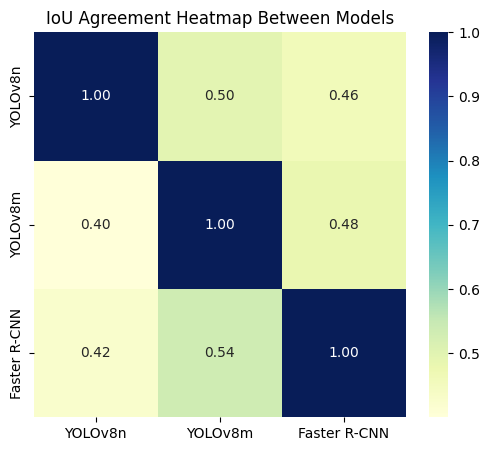

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# IoU-покрытие для одной пары моделей
def iou_agreement(boxes_a, boxes_b, iou_thresh=0.5):
    matched = 0
    for a in boxes_a:
        if any(compute_iou(a, b) >= iou_thresh for b in boxes_b):
            matched += 1
    return matched / max(1, len(boxes_a))

# Считаем среднюю сходимость по датасету
def iou_matrix(all_a, all_b):
    scores = []
    for a_boxes, b_boxes in zip(all_a, all_b):
        scores.append(iou_agreement(a_boxes, b_boxes))
    return np.mean(scores)

# Построим матрицу
iou_values = np.array([
    [1.0,
     iou_matrix(boxes_yolo_n, boxes_yolo_m),
     iou_matrix(boxes_yolo_n, boxes_faster_rcnn)],
    [iou_matrix(boxes_yolo_m, boxes_yolo_n),
     1.0,
     iou_matrix(boxes_yolo_m, boxes_faster_rcnn)],
    [iou_matrix(boxes_faster_rcnn, boxes_yolo_n),
     iou_matrix(boxes_faster_rcnn, boxes_yolo_m),
     1.0]
])

labels = ["YOLOv8n", "YOLOv8m", "Faster R-CNN"]
plt.figure(figsize=(6, 5))
sns.heatmap(iou_values, xticklabels=labels, yticklabels=labels, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("IoU Agreement Heatmap Between Models")
plt.show()

In [30]:
# Считаем разницу между количеством боксов у моделей
disagreement_scores = []
for i, (b1, b2, b3) in enumerate(zip(boxes_yolo_n, boxes_yolo_m, boxes_faster_rcnn)):
    n1, n2, n3 = len(b1), len(b2), len(b3)
    score = max(abs(n1 - n2), abs(n1 - n3), abs(n2 - n3))
    disagreement_scores.append((i, score))

# Сортируем по убыванию разногласий
disagreement_scores.sort(key=lambda x: x[1], reverse=True)

# Выводим топ-5 изображений с наибольшими расхождениями
print("Наибольшие расхождения в количестве bbox:")
for i, score in disagreement_scores[:5]:
    print(f"{i}: {image_paths[i]} — различие: {score} bbox")

Наибольшие расхождения в количестве bbox:
57: People-Detection-1/train/images/000013_jpg.rf.b104518c90da6c171672b2fb2edc57e7.jpg — различие: 17 bbox
63: People-Detection-1/train/images/000024_jpg.rf.ba1c4e856428071d78ba1d62e0f192a1.jpg — различие: 16 bbox
65: People-Detection-1/train/images/000047_jpg.rf.0fb987e6ed18968ebffdcbdac8f389ab.jpg — различие: 13 bbox
71: People-Detection-1/train/images/000054_jpg.rf.15bb27cced803eb9eddb34b154d6b417.jpg — различие: 13 bbox
88: People-Detection-1/train/images/000088_jpg.rf.d916ad17fda8dbcc1137edb8e1ef40cb.jpg — различие: 13 bbox


## Создание финального датасета

Теперь финальная часть - создание датасета.
В реальной практике, когда происходит перекрестная разметка несколькими разметчиками, для того чтобы взять эталлонный gt можно использовать концепцию пересечения как минимум 2 моделей. То есть мы считаем что лейбл "истинный", если есть пересечение разметки

#### **Задание(5 балла)**:
Напишите код, для того чтобы создать финальный датасет. Финальный датасет содержит лейблы, если есть пересечение минимум 2 моделей

In [55]:
def is_supported_by_others(box, others, iou_thresh=0.5) -> bool:
    """
    Проверяет, был ли bbox поддержан как минимум двумя другими источниками (моделями).

    Параметры:
        box (List[float]): текущий bbox в формате [x1, y1, x2, y2]
        others (List[List[List[float]]]): список bbox'ов от других моделей
        iou_thresh (float): порог IoU для согласия (по умолчанию 0.5)

    Возвращает:
        bool: True, если bbox подтверждён ≥ 2 другими источниками
    """
    # ---- Ваш код здесь ----
    check = lambda im: np.array(list(map(lambda b: compute_iou(box, b), im))) >= 0.5
    res =[np.any(check(img)) for img in others]
    result = sum(np.array(res)) >= 2
    return result

# Финальный датасет: bbox'ы, подтверждённые ≥2 моделями
final_dataset = []

for b1, b2, b3 in zip(boxes_yolo_n, boxes_yolo_m, boxes_faster_rcnn):
    all_boxes = b1.tolist() + b2.tolist() + b3.tolist()
    # Убираем повторы
    unique_boxes = []
    for box in all_boxes:
        if not any(compute_iou(box, u) > 0.95 for u in unique_boxes):
            unique_boxes.append(box)

    # Фильтрация: оставляем только bbox с подтверждением
    accepted = []
    for box in unique_boxes:
        if is_supported_by_others(box, [b1, b2, b3]):
            accepted.append(box)
    final_dataset.append(accepted)

In [ ]:
a = np.array([0.3, 0.7, 0.6])
a = a >= 0.5
sum(a) >= 2

np.True_

In [ ]:
print(len(boxes_yolo_n), len(boxes_yolo_m), len(boxes_faster_rcnn))

25 25 25


In [56]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize_final_boxes(image_paths, final_dataset, n=5):
    plt.figure(figsize=(15, 3 * n))
    for i in range(n):
        img = Image.open(image_paths[i])
        boxes = final_dataset[i]

        ax = plt.subplot(n, 1, i + 1)
        ax.imshow(img)
        for box in boxes:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, "person", color='lime', fontsize=10)
        ax.set_title(f"Image {i+1}: {os.path.basename(image_paths[i])}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

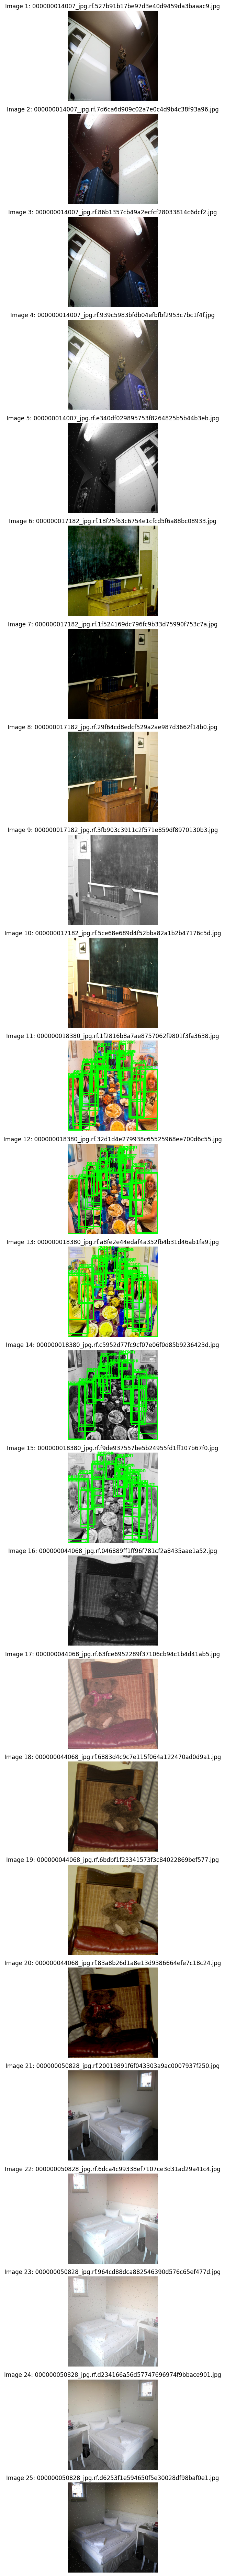

In [57]:
visualize_final_boxes(image_paths, final_dataset, n=25)  # можно изменить n